In [9]:
%load_ext autoreload
%autoreload 2

import torch
from torchvision.transforms import ToTensor
from torch.optim import Adam

from context import *
from LocalLearning import Attacks
from LocalLearning import KHModel, FKHL3, SHLP
from LocalLearning import Data
from LocalLearning import Trainers

from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
plt.style.use(['seaborn-paper', "./PRLDoubleCol.mplstyle"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# HYPERPARAMETERS
# train flip switch 
TRAIN = True

BATCH_SIZE = 1000
NUMBER_OF_EPOCHS = 1000
LEARNING_RATE = 1e-3

model_path = Path("../data/ICLR/models")
figure_path = Path("../data/ICLR/figures")

khlayer_name = Path("fkhl3_cifar10_pruned_thr.pty")
khmodel_name = Path("khmodel_cifar10.pty")
khmodel_log_name = Path("khmodel_cifar10_log.json")

In [ ]:
cmap = {
    "kh": '#1b9e77', #"#762a83",
    "hybrid": '#d95f02', #"#f8a953",
    "bp": '#7570b3', #"#1b7837",#"#106151",
}

#1b9e77
#d95f02
#7570b3

In [4]:
# load the local learning model
state_dict = torch.load(model_path / khlayer_name)
khlayer = FKHL3(state_dict)

# build the KHModel
khmodel = KHModel(khlayer, no_classes=10)
khmodel.to(device)

KHModel(
  (relu_h): ReLU()
  (softMax): Softmax(dim=-1)
  (local_learning): FKHL3(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (dense): Linear(in_features=2000, out_features=10, bias=True)
)

In [5]:
# define training and test datasets for training
cifar10Train= Data.LpUnitCIFAR10(
    root="../data/CIFAR10",
    train=True,
    transform=ToTensor(),
    p=khlayer.pSet["p"],
)

TrainLoader = Data.DeviceDataLoader(
    cifar10Train,# define batch window in the global index coordinates
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=True,
)

cifar10Test = Data.LpUnitCIFAR10(
    root="../data/CIFAR10",
    train=False,
    transform=ToTensor(),
    p=khlayer.pSet["p"],
)

TestLoader = Data.DeviceDataLoader(
    cifar10Test,
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False,
)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
if TRAIN:
    khmodel.train()
    ce_trainer = Trainers.CETrainer(khmodel, device)
    ce_trainer.run(TrainLoader, TestLoader, no_epochs=NUMBER_OF_EPOCHS)
    ce_trainer.save(model_path / khmodel_name, model_path / khmodel_log_name)

  0%|          | 0/1000 [00:00<?, ?epoch/s]

In [12]:
log = Trainers.Trainer.Logger()
log.load(model_path / khmodel_log_name)

In [18]:
log.keys()

dict_keys(['epoch', 'loss', 'ce_loss', 'eval_acc'])

Text(0, 0.5, 'Test accuracy')

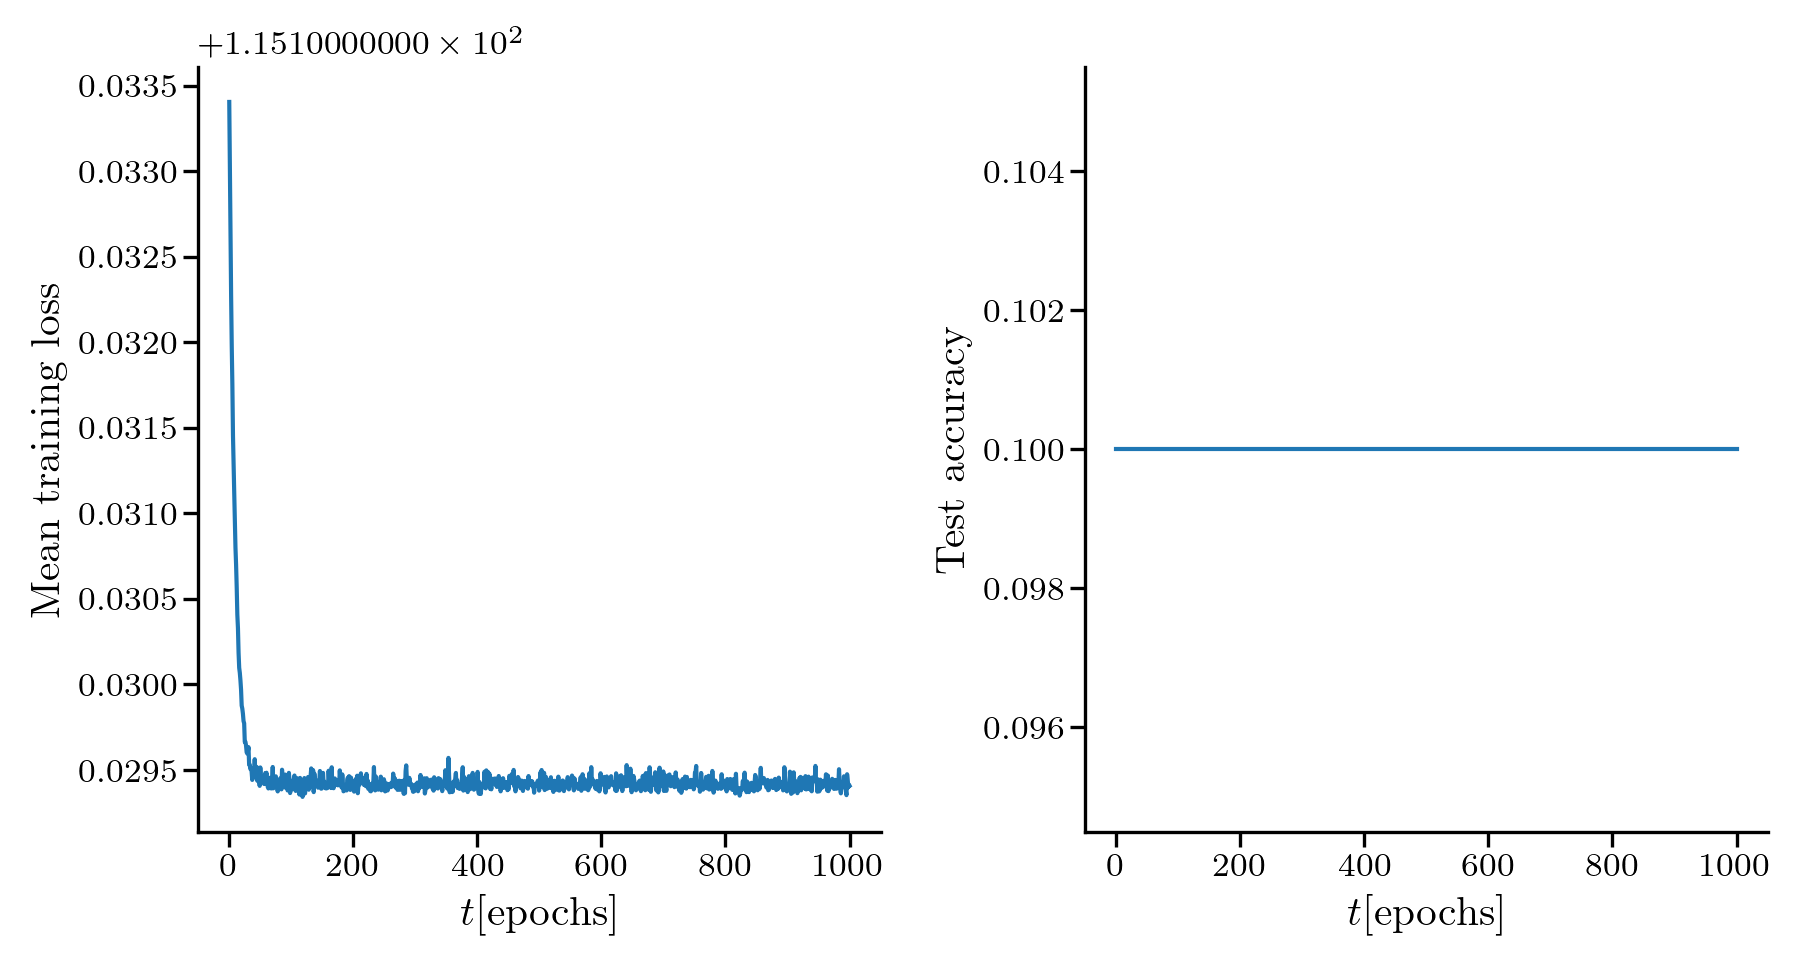

In [19]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(np.array(log["epoch"]), np.array(log["loss"]))
axs[0].set_xlabel(r"$t [\textrm{epochs}]$")
axs[0].set_ylabel(r"Mean training loss")

axs[1].plot(np.array(log["epoch"]), np.array(log["eval_acc"]))
axs[1].set_xlabel(r"$t [\textrm{epochs}]$")
axs[1].set_ylabel(r"Test accuracy")